### Imports

In [1]:
from __future__ import print_function, division
import os, mimetypes
import sys
import torch
import pandas as pd
from collections import defaultdict
import PIL
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from pathlib import Path
from random import shuffle
from scipy import ndimage
#from torchsummary import summary
import torch.nn as nn
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
if sys.platform == 'linux':
    path = Path('/home/ec2-user/SageMaker/data')
else:
    path = Path('C:/Users/francesco.pochetti/Downloads/imagenette')

In [35]:
#import torchvision.datasets as dset
#import torchvision.transforms as transforms
#cap = dset.CocoCaptions(root = path/'coco-images'/'test2015',
#                        annFile = path/'coco-labels'/'image_info_test2015.json')

In [36]:
#print('Number of samples: ', len(cap))

In [37]:
#img, target = cap[random.randint(0, len(cap)-1)]; img

### Restructure dataset in convenient way

In [2]:
content_path = path/'coco-images'/'test2015'
content_path

PosixPath('/home/ec2-user/SageMaker/data/coco-images/test2015')

In [3]:
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [4]:
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res
                
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [5]:
files = get_files(content_path, image_extensions, recurse=True)
len(files)

81434

In [6]:
van_gogh_path = path/'styles'/'VanGogh.png' 
van_gogh_path

PosixPath('/home/ec2-user/SageMaker/data/styles/VanGogh.png')

In [7]:
contents = files
styles = [van_gogh_path] * len(contents)

In [9]:
te_ = int(len(styles) * 0.001)
tr_ = len(styles) - te_
assert(len(styles) == (te_+tr_))
print(te_, tr_)

splits = ['valid'] * te_ + ['train'] * tr_ 
shuffle(splits)

81 81353


In [26]:
df = pd.DataFrame({'content_': contents, 'style_': styles, 'split_': splits})
df.head()

,content_,style_,split_
0,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/VanGogh.png,train
1,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/VanGogh.png,train
2,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/VanGogh.png,train
3,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/VanGogh.png,train
4,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/VanGogh.png,train


In [31]:
style_img = PIL.Image.open(df.sample().style_.iloc[0])

In [32]:
(style_img.size + (3,))

(684, 540, 3)

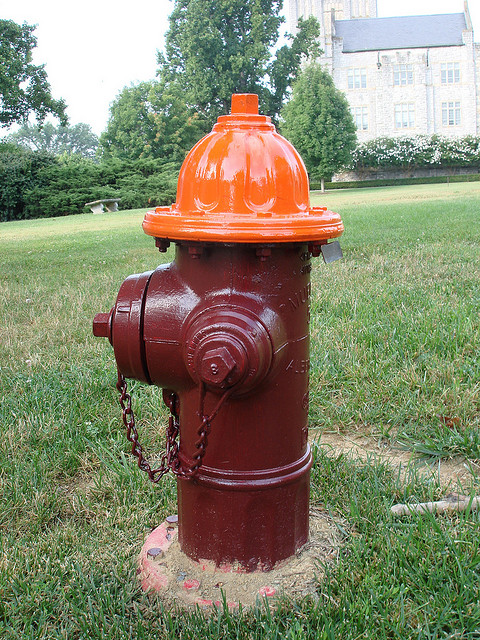

In [33]:
content_img = PIL.Image.open(df.sample().content_.iloc[0]); content_img

In [34]:
df.to_csv(path/'dataset.csv', index=False)

### Unit tests

In [2]:
def test_data(dl, ds):
    assert dl['train'].dataset == ds['train']
    assert dl['valid'].dataset == ds['valid']
    
    assert abs(len(ds['train'])/bs - len(dl['train'])) < 2
    assert abs(len(ds['valid'])/bs - len(dl['valid'])) < 2
    
    i,c,s = next(iter(dl['train']))
    assert i.shape[0] == bs
    assert i.shape[1] == 3
    assert i.shape[2] == i.shape[3] == size 

    i,c,s = next(iter(dl['valid']))
    assert i.shape[0] == bs
    assert i.shape[1] == 3
    assert i.shape[2] == i.shape[3] == size 

def test_deprocess(ds_item):
    denorm = DeProcess(imagenet_stats)
    d = denorm(ds_item)
    return PIL.Image.fromarray(d[random.choice([0,1,2])])    

def test_hooks():
    fst = FastStyleTransfer(dataloaders, *get_model_opt())
    assert fst.hooks_initialized == True
    d = random.choice(['train', 'valid'])
    i, c, s = next(iter(fst.dl[d]))
    i = i.to(fst.device)
    c = c.to(fst.device)
    s = s.to(fst.device)
    assert torch.allclose(i, c)
    assert torch.allclose(i, s) == False

    fst.vgg(i)
    input_act = [o.features.clone().detach_().to(fst.device) for o in fst.act]
    fst.vgg(c)
    content_act = [o.features.clone().detach_().to(fst.device) for o in fst.act]
    fst.vgg(s)
    style_act = [o.features.clone().detach_().to(fst.device) for o in fst.act]

    assert len(input_act) == len(content_act) == len(style_act) == 5
    assert torch.allclose(input_act[1], content_act[1])
    assert torch.allclose(input_act[3], content_act[3])
    assert style_act[0].shape[0] == style_act[2].shape[0] == style_act[4].shape[0] == bs
    fst.close_hooks()
    assert fst.hooks_initialized == False
        
def test_losses():
    fst = FastStyleTransfer(dataloaders, *get_model_opt())
    assert fst.hooks_initialized == True
    d = random.choice(['train', 'valid'])
    i, c, s = next(iter(fst.dl[d]))
    i = i.to(fst.device)
    c = c.to(fst.device)
    s = s.to(fst.device)
    assert torch.allclose(i, c)
    assert torch.allclose(i, s) == False

    fst.vgg(i)
    input_act = [o.features.clone().detach_().to(fst.device) for o in fst.act]
    fst.vgg(c)
    content_act = [o.features.clone().detach_().to(fst.device) for o in fst.act]
    fst.vgg(s)
    style_act = [o.features.clone().detach_().to(fst.device) for o in fst.act]
    
    co_loss = fst.content_mse(input_act[0], content_act[0])
    assert isinstance(co_loss, torch.Tensor)
    
    st_loss = fst.gram_mse_loss(input_act[4], style_act[4])
    assert isinstance(st_loss, torch.Tensor)
    
    fst.input_act = input_act
    fst.content_act = content_act
    fst.style_act = style_act
    loss, content, style = fst.combined_loss()
    assert isinstance(st_loss, torch.Tensor)
    fst.close_hooks()
    assert fst.hooks_initialized == False

### Prepare the dataset/dataloader

In [3]:
class StyleTransferDataset(Dataset):
    """Style Transfer dataset."""

    def __init__(self, csv_file, train_test, transform=None, sample=None):
        data = pd.read_csv(csv_file)
        if sample: data = data.sample(int(len(data)*sample))
        self.train_test = train_test
        data.loc[:,['content_', 'style_']] = data.loc[:,['content_', 'style_']].applymap(lambda x: Path(x))
        self.data = data.loc[data.split_==train_test,:].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        item = self.__getitem__(0)
        
        _1 = f'{self.train_test.capitalize()} dataset: {len(self.data)} items\n'
        _2 = f'Item: {type(item)} of {len(item)} {type(item[0])}\n'
        _3 = f"Item example: 'input':{ item[0].shape},'content':{item[1].shape},'style':{item[2].shape}"

        return _1+_2+_3
    
    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        content_img = self.data.content_.iloc[idx]
        content_img = PIL.Image.open(content_img)
        
        style_img = self.data.style_.iloc[idx]
        style_img = PIL.Image.open(style_img)
        
        #opt_img = np.random.uniform(0, 1, size=(content_img.size + (3,))).astype(np.float32)
        #opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
        #item = {'input': content_img, #PIL.Image.fromarray(np.uint8(opt_img*255)),
        #        'content': content_img, 
        #        'style': style_img}
        
        item = {'content': content_img, 
                'style': style_img}

        
        if self.transform: item = compose(item, self.transform)

        return item['content'], item['content'], item['style']

In [4]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(list(funcs), key=key): x = f(x, **kwargs)
    return x

class Transform(): _order=0
        
class MakeRGB(Transform):
    def __call__(self, item): return {k: v.convert('RGB') for k, v in item.items()}

class ResizeFixed(Transform):
    _order=10
    def __init__(self, size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return {k: v.resize(self.size, PIL.Image.BILINEAR) for k, v in item.items()}

class ToByteTensor(Transform):
    _order=20
    def to_byte_tensor(self, item):
        res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
        w,h = item.size
        return res.view(h,w,-1).permute(2,0,1)
    
    def __call__(self, item): return {k: self.to_byte_tensor(v) for k, v in item.items()}


class ToFloatTensor(Transform):
    _order=30
    def to_float_tensor(self, item): return item.float().div_(255.)
    
    def __call__(self, item): return {k: self.to_float_tensor(v) for k, v in item.items()}
    
class Normalize(Transform):
    _order=40
    def __init__(self, stats):
        self.mean = torch.as_tensor(stats[0] , dtype=torch.float32)
        self.std = torch.as_tensor(stats[1] , dtype=torch.float32)
    
    def normalize(self, item): return item.sub_(self.mean[:, None, None]).div_(self.std[:, None, None])
    
    def __call__(self, item): return {k: self.normalize(v) for k, v in item.items()}
    
class PilRandomDihedral(Transform):
    _order=15
    def __init__(self, p=0.75): self.p=p*7/8 #Little hack to get the 1/8 identity dihedral transform taken into account.
    
    def __call__(self, item):
        if random.random()>self.p: return item
        return {k: v.transpose(random.randint(0,6)) for k, v in item.items()}
    
class DeProcess(Transform):
    _order=50
    def __init__(self, stats):
        self.mean = torch.as_tensor(stats[0] , dtype=torch.float32)
        self.std = torch.as_tensor(stats[1] , dtype=torch.float32)
    
    def de_normalize(self, item): return (item*self.std[:, None, None]+self.mean[:, None, None])*255.
    def rearrange_axis(self, item): return np.moveaxis(item, 0, -1)
    def to_np(self, item): return np.uint8(np.array(item))
    def de_process(self, item): return self.rearrange_axis(self.to_np(self.de_normalize(item)))
    
    def __call__(self, item): 
        if isinstance(item, torch.Tensor): return self.de_process(item) 
        if isinstance(item, tuple): return tuple([self.de_process(v) for v in item])
        if isinstance(item, dict): return {k: self.de_process(v) for k, v in item.items()}

In [29]:
#class Sampler():
#    def __init__(self, ds, bs, shuffle=False):
#        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
#        
#    def __iter__(self):
#        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
#        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]
            
#def collate(b):
#    inputs,contents,styles = zip(*b)
#    return torch.stack(inputs),torch.stack(contents),torch.stack(styles)

#class DataLoader():
#    def __init__(self, ds, sampler, collate_fn=collate):
#        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
#        
#    def __iter__(self):
#        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

### ResNetUnet

In [5]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out        
    
class SaveFeatures():
    features=None
    
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output): 
        self.features = output
    
    def close(self): 
        self.hook.remove()

def gram(input):
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel() #*1e6
    
def content2style(dataloaders): # NOT WORKING! TO BE REFACTORED
    activations = [SaveFeatures(list(vgg.features)[idx]) for idx in convs]
    content = 0
    style = 0
    for i, (inputs, contents, styles) in enumerate(dataloaders['train']):
        if i == 4: break
        
        inputs = inputs.to(device)
        contents = contents.to(device)
        styles = styles.to(device)

        vgg(contents)
        target_cont = [o.features.clone().detach_().to(device) for o in activations]

        vgg(styles)
        target_style = [o.features.clone().detach_().to(device) for o in activations]

        outputs = model(inputs)
        vgg(outputs)
        opt_cat = [o.features.clone().to(device) for o in activations]

        _, content_loss, style_loss = combined_loss(opt_cat, target_style, target_cont)
        
        content += content_loss.cpu().detach().numpy()
        style += style_loss.cpu().detach().numpy()
    
    for sf in activations: sf.close()
    return content/(style+1)

In [55]:
class FastStyleTransfer():
    def __init__(self, dl, model, opt, sched=None, style_weight=1e10, content_weight=1e5, tv_weight=1e5):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.mseloss = nn.MSELoss()
        self.init_vgg()
        self.convs = [i-3 for i,o in enumerate(list(self.vgg.features)) if isinstance(o,nn.MaxPool2d)]
        self.model = model.to(self.device)
        self.original_model = model.to(self.device)
        self.opt = opt
        self.sched = sched
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.tv_weight = tv_weight
        self.dl = dl
        self.initialize_hooks()
        self.style_act = None
        
    def init_vgg(self):
        self.vgg = models.vgg16_bn(pretrained=True).to(self.device)
        self.vgg.eval()
    
    def reinitialize_unet(self): self.model = copy.deepcopy(self.original_model)
        
    def initialize_hooks(self): 
        self.act = [SaveFeatures(list(self.vgg.features)[idx]) for idx in self.convs]
        self.hooks_initialized = True
    
    def close_hooks(self): 
        for hook in self.act: hook.close()
        self.hooks_initialized = False
        
    def vgg_conv_layers(self): return np.array(list(self.vgg.features))[self.convs]
    
    def content_mse(self, input, target): return self.mseloss(input, target) #*1e3

    def gram_mse_loss(self, input, target): return self.mseloss(gram(input), gram(target))

    def get_tv_loss(self, input):
        l = (torch.sum(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) + 
             torch.sum(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :])))
        return l
    
    def combined_loss(self, c2s=1.0, input=None):
        style_losses = [self.gram_mse_loss(o, s) for o,s in zip(self.input_act, self.style_act)]
        
        #content_losses = [content_mse(o, s) for o,s in zip(opt_cat, target_cont)]
        content_losses = [self.content_mse(self.input_act[2], self.content_act[2])]
        
        style = sum(style_losses) * c2s * self.style_weight
        content = sum(content_losses) * self.content_weight
        loss = content + style
        if input: loss += self.tv_loss(input) * self.tv_weight
        return loss, content, style
    
    def store_metrics(self, phase, epoch, i, inputs):
        self.metrics[phase]['epoch'] += [epoch]
        self.metrics[phase]['batch'] += [i]
        self.metrics[phase]['batch_size'] += [inputs.size(0)]
        self.metrics[phase]['total_loss'] += [self.loss.cpu().detach().numpy()]
        self.metrics[phase]['content_loss'] += [self.content_loss.cpu().detach().numpy()]
        self.metrics[phase]['style_loss'] += [self.style_loss.cpu().detach().numpy()]
        
    def get_epoch_loss(self, phase):
        d = pd.DataFrame(self.metrics[phase])
        d = d.groupby('epoch')['total_loss','batch_size'].apply(lambda x : x.sum()). \
            reset_index().sort_values(by='epoch').tail(1)   
        d = d.total_loss/d.batch_size
        return np.array(d)[0]
    
    def get_metrics(self, phase):
        df = pd.DataFrame(self.metrics[phase])
        df['total'] = df.total_loss/df.batch_size
        df['content'] = df.content_loss/df.batch_size
        df['style'] = df.style_loss/df.batch_size
        df['epoch-batch'] = df.epoch.map(str)+'-'+df.batch.map(str)
        return df

    def plot_losses(self, phase):
        df = self.get_metrics(phase)
        x_axis = min(18, int(0.03*len(df)))
        fig, ax = plt.subplots(figsize=(x_axis, 5))
        df.plot(ax=ax, x='epoch-batch', y=['total', 'content', 'style'])
        plt.show()

    def run_st(self, tensor):
        out = self.model(tensor[None].to(self.device))
        return out[0].detach().cpu()
    
    def plot_samples(self, phase):
        ds = self.dl[phase].dataset
        idx = random.sample(range(len(ds)), 3)
        denorm = DeProcess(imagenet_stats)
        items = [denorm((self.run_st(ds[i][0]), *ds[i][1:])) for i in idx]

        fig, axes = plt.subplots(3,3, figsize=(8,8))
        for i in range(3):
            for j in range(3):
                ax = axes[i, j]
                ax.imshow(items[i][j])
                ax.axis('off')
        #fig.suptitle(f'Random images from {phase}-set (styled-image, original, style applied)')
        plt.subplots_adjust(wspace=0.01, hspace=0.01)
        plt.show()
    
    def train(self, num_epochs=3, print_every=500):
        if not self.hooks_initialized: self.initialize_hooks()
        self.metrics =  defaultdict(lambda: defaultdict(list))
        #c2s = content2style(dataloaders)

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-' * 10)
            since = time.time()

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                print(f'Phase: {phase}')
                if phase == 'train':
                    if self.sched is not None:
                        self.sched.step()
                        for param_group in self.opt.param_groups:
                            print("LR", param_group['lr'])
                    
                    self.model.train() 
                else:
                    self.model.eval()
                    save_model_filename = ["epoch", str(epoch),  
                                           str(time.ctime()).replace(' ', '_'), 
                                           str(self.content_weight),
                                           str(self.style_weight) + ".model"]
                    torch.save(self.model.state_dict(), '_'.join(save_model_filename))

                if self.style_act is not None: self.style_act = None
                
                for i, (inputs, contents, styles) in enumerate(self.dl[phase]):
                    inputs = inputs.to(self.device)
                    contents = contents.to(self.device)
                    styles = styles.to(self.device)
                    if i % print_every == 0: print(f'batch: {i}: shapes of (input, content, style) = {inputs.shape}, {contents.shape}, {styles.shape}')

                    self.vgg(contents)
                    self.content_act = [o.features.clone().detach_().to(self.device) for o in self.act]

                    if self.style_act is None or i == (len(self.dl[phase])-1):
                        self.vgg(styles)
                        self.style_act = [o.features.clone().detach_().to(self.device) for o in self.act]

                    self.opt.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        self.vgg(outputs)
                        self.input_act = [o.features.clone().to(self.device) for o in self.act]
                        #tv_loss = get_tv_loss(contents)
                        self.loss, self.content_loss, self.style_loss = self.combined_loss()
                        self.store_metrics(phase, epoch, i, inputs)
                        
                        if phase == 'train':
                            self.loss.backward()
                            self.opt.step()
                
                epoch_loss = self.get_epoch_loss(phase)
                if phase == 'train': 
                    print(f"phase: {phase}, loss: {epoch_loss}")
                    self.plot_losses(phase)
                self.plot_samples(phase)

            time_elapsed = time.time() - since
            print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        self.close_hooks()
        return
    
def get_model_opt(sched=None):
    unet = ResNetUNet(3)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, unet.parameters()), lr=1e-3)
    if sched: sched = lr_scheduler.CosineAnnealingLR(optimizer, 50)
    return [unet, optimizer, sched]

#device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH, map_location=device))
#https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [48]:
bs = 4
sample = 0.05
size = 256

rgb = MakeRGB()
resized = ResizeFixed(size)
tobyte = ToByteTensor()
tofloat = ToFloatTensor()
norm = Normalize(imagenet_stats)
aug = PilRandomDihedral()

tmfs = [rgb, resized, tobyte, tofloat, norm]

train_ds = StyleTransferDataset(path/'dataset.csv', train_test='train', transform=tmfs, sample=0.001)
valid_ds = StyleTransferDataset(path/'dataset.csv', train_test='valid', transform=tmfs, sample=0.2)

dataloaders = {'train': DataLoader(train_ds, batch_size=bs, shuffle=True),
              'valid': DataLoader(valid_ds, batch_size=bs)}

Valid dataset: 15 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 256, 256]),'content':torch.Size([3, 256, 256]),'style':torch.Size([3, 256, 256])
Train dataset: 81 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 256, 256]),'content':torch.Size([3, 256, 256]),'style':torch.Size([3, 256, 256])
train 12


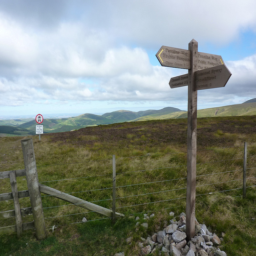

In [49]:
print(valid_ds)
print(train_ds)

datasets = {'train': train_ds, 'valid': valid_ds}
d = random.choice(['train', 'valid'])
i = random.choice(range(len(datasets[d])))
print(d, i)

test_data(dataloaders, datasets)
test_deprocess(datasets[d][i])

In [34]:
test_hooks()
test_losses()

In [42]:
#d = pd.DataFrame(fst.metrics['train'])
#d = d.groupby('epoch')['total_loss','batch_size'].apply(lambda x : x.sum()).reset_index().sort_values(by='epoch').tail(1)   
#d = d.total_loss/d.batch_size
#np.array(d)[0]

In [56]:
fst = FastStyleTransfer(dataloaders, *get_model_opt(), style_weight=1e12)

In [57]:
fst.train(num_epochs=1)

Epoch 0/0
----------
Phase: train
batch: 0: shapes of (input, content, style) = torch.Size([4, 3, 256, 256]), torch.Size([4, 3, 256, 256]), torch.Size([4, 3, 256, 256])


KeyboardInterrupt: 

In [29]:
#def train_model(model, optimizer, scheduler, num_epochs=25):

#model = ResNetUNet(3).to(device)

#optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 50)

def train(model, vgg, optimizer, scheduler, num_epochs=3):
    
    activations = [SaveFeatures(list(vgg.features)[idx]) for idx in convs]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    metrics =  defaultdict(lambda: defaultdict(list))
    
    #c2s = content2style(dataloaders)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            print(phase)
            print()
            if phase == 'train':
                pass
                #scheduler.step()
                #for param_group in optimizer.param_groups:
                #    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_samples = 0
            epoch_loss = 0.0

            if 'target_style' in locals(): del target_style

            for i, (inputs, contents, styles) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                contents = contents.to(device)
                styles = styles.to(device)
                if i % 300 == 0:
                    print(f'batch: {i}', inputs.shape, contents.shape, styles.shape)

                vgg(contents)
                target_cont = [o.features.clone().detach_().to(device) for o in activations]

                if 'target_style' not in locals() or i == (len(dataloaders[phase])-1):
                    vgg(styles)
                    target_style = [o.features.clone().detach_().to(device) for o in activations]
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    vgg(outputs)
                    opt_cat = [o.features.clone().to(device) for o in activations]
                    #tv_loss = get_tv_loss(contents)

                    loss, content_loss, style_loss = combined_loss(opt_cat, target_style, target_cont)

                    metrics[phase]['epoch'] += [epoch]
                    metrics[phase]['batch'] += [i]
                    metrics[phase]['batch_size'] += [inputs.size(0)]
                    metrics[phase]['total_loss'] += [loss.cpu().detach().numpy()]
                    metrics[phase]['content_loss'] += [content_loss.cpu().detach().numpy()]
                    metrics[phase]['style_loss'] += [style_loss.cpu().detach().numpy()]
                    #metrics[phase]['tv_loss'] += [tv_loss.cpu().detach().numpy()]

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                epoch_loss += loss.cpu().detach().numpy()

            epoch_loss = epoch_loss / epoch_samples

            # deep copy the model
            if phase == 'valid' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            print(f"phase: {phase}, loss: {epoch_loss}")

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    for sf in activations: sf.close()
    
    return model, metrics

In [19]:
model, metrics = train(model, vgg, optimizer, scheduler, num_epochs=2)

Epoch 0/1
----------
train

batch: 0 torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160])
batch: 300 torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160])
batch: 600 torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160])
batch: 900 torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160])
batch: 1200 torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160])
phase: train, loss: 56.41714314784342
valid

batch: 0 torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160])
batch: 300 torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160])
saving best model
phase: valid, loss: 45.53147324098412
25m 32s
Epoch 1/1
----------
train

batch: 0 torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160]) torch.Size([8, 3, 160, 160])
batch: 300 torch.Size([8, 3, 160, 160]) torch.Size([8, 3

### Random Tests

In [18]:
out = fst.model(valid_ds[0][1][None].to(fst.device))

In [19]:
out = out[0].detach().cpu()

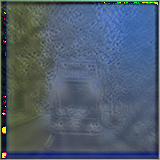

In [20]:
denorm = DeProcess(imagenet_stats)
d = denorm(out)
PIL.Image.fromarray(d)

In [39]:
def run_st(tensor):
    out = fst.model(tensor[None].to(fst.device))
    return out[0].detach().cpu()

In [68]:
idx = np.random.randint(0, len(valid_ds)-1, size=3)
denorm = DeProcess(imagenet_stats)
items = [denorm((run_st(valid_ds[i][0]), *valid_ds[i][1:])) for i in idx]

fig, axes = plt.subplots(3,3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.imshow(items[i][j])
        ax.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)

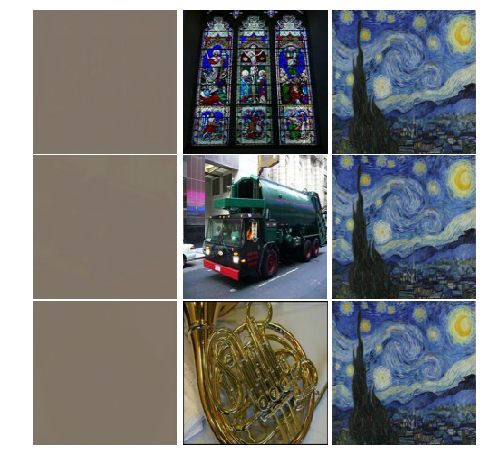

In [69]:
fig, axes = plt.subplots(3,3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.imshow(items[i][j])
        ax.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)

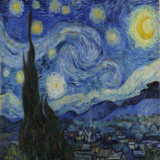

In [15]:
denorm = DeProcess(imagenet_stats)
d = denorm(valid_ds[0][2])
PIL.Image.fromarray(d)

In [15]:
target_cont[0].shape

torch.Size([16, 64, 128, 128])

In [16]:
target_style[0].shape

torch.Size([7, 64, 128, 128])

In [19]:
len(dataloaders['train'])

670

In [19]:
x = unet(i.to(device))
x.shape

torch.Size([4, 3, 128, 128])

In [22]:
vgg = models.vgg16_bn(pretrained=True).to(device)
vgg = vgg.eval()
#model.features

In [24]:
convs = [i-3 for i,o in enumerate(list(vgg.features)) if isinstance(o,nn.MaxPool2d)]
print(np.array(list(vgg.features))[convs])

[Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


In [110]:
input = train_ds[0][0][None]
original_t = train_ds[0][1]
style_t = train_ds[0][2]

In [97]:
activations = [SaveFeatures(list(model.features)[idx]) for idx in convs]

In [99]:
model(original_t[None])
target_cont = [o.features.clone() for o in activations]

model(style_t[None])
target_style = [o.features.clone() for o in activations]

In [103]:
[t.shape for t in target_style]

[torch.Size([1, 64, 128, 128]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 512, 16, 16]),
 torch.Size([1, 512, 8, 8])]

In [132]:
content_loss(input, target_cont)

tensor(0.7885, grad_fn=<AddBackward0>)

In [133]:
style_loss(input, target_style)

tensor(2.5175e-06, grad_fn=<AddBackward0>)

In [131]:
combined_loss(input, target_style, target_cont)

tensor(0.3942, grad_fn=<AddBackward0>)

In [64]:
#summary(unet, input_size=(3, 128, 128))

In [141]:
for i,c,s in dataloaders['train']:
    print(i.shape, c.shape, s.shape)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64, 3, 128, 128]) torch.Size([64, 3, 128, 128])
